# Chapter 2: Working with Text Data

In [6]:
import torch, tiktoken

device = "cuda" if torch.cuda.is_available() else "cpu"

device, torch.__version__, tiktoken.__version__ 

('cuda', '2.7.1+cu126', '0.9.0')

## 2.1 Tokenizing text

In [7]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
        url = ("https://raw.githubusercontent.com/rasbt/"
                "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
                "the-verdict.txt")
        file_path = "the-verdict.txt"
        urllib.request.urlretrieve(url, file_path)

In [8]:
with open ("the-verdict.txt", "r") as f:
    raw_text = f.read()
    
print(f"Number of chars = {len(raw_text)}")
print(raw_text[:100])

Number of chars = 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [9]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [10]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [11]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [12]:
def preprocess(raw_text):
    preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
    preprocessed = [item.strip() for item in preprocessed if item.strip()]
    
    return preprocessed

In [13]:
preprocessed = preprocess(raw_text)
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## 2.2 Converting tokens into token IDs

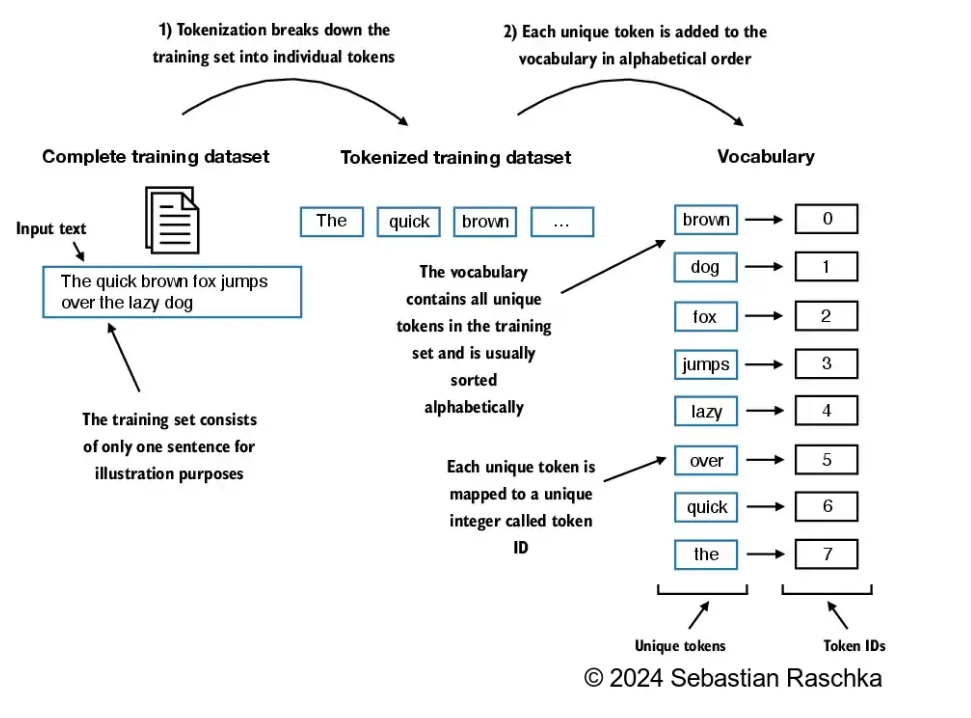

In [14]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

vocab_size

1130

In [21]:
vocab = {token:ID for ID, token in enumerate(all_words)}
# vocab

In [ ]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:word for word, i in vocab.items()}
        
    # Turns text into token ids
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    # Turns token ids into text
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [ ]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
            Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [23]:
text = tokenizer.decode(ids)
print(text)

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


## 2.3 Adding special tokens

Some tokenizers use special tokens to help the LLM with additional context

Some of these special tokens are:
- `[BOS]` (beginning of sequence) marks the beginning of text
- `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
- `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
- `[UNK]` to represent words that are not included in the vocabulary
  
Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity

The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above

GPT also uses the `<|endoftext|>` for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)

GPT-2 does not use an <UNK> token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section

In [24]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

In [36]:
all_tokens = sorted(set(preprocessed))

all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [37]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [38]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        
        # NEW
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [39]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [40]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [41]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

## 2.4 BytePair encoding

- GPT-2 used BytePair encoding (BPE) as its tokenizer
- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The original BPE tokenizer can be found here: https://github.com/openai/gpt-2/blob/master/src/encoder.py

In [ ]:
import tiktoken

# Like we init our class tokenizer with a dict of vocab we need to init this with the vocab dict we want (eg. gpt2)
tokenizer = tiktoken.get_encoding("gpt2")
tokenizer

<Encoding 'gpt2'>

In [44]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
    "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [45]:
string = tokenizer.decode(integers)

print(string)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


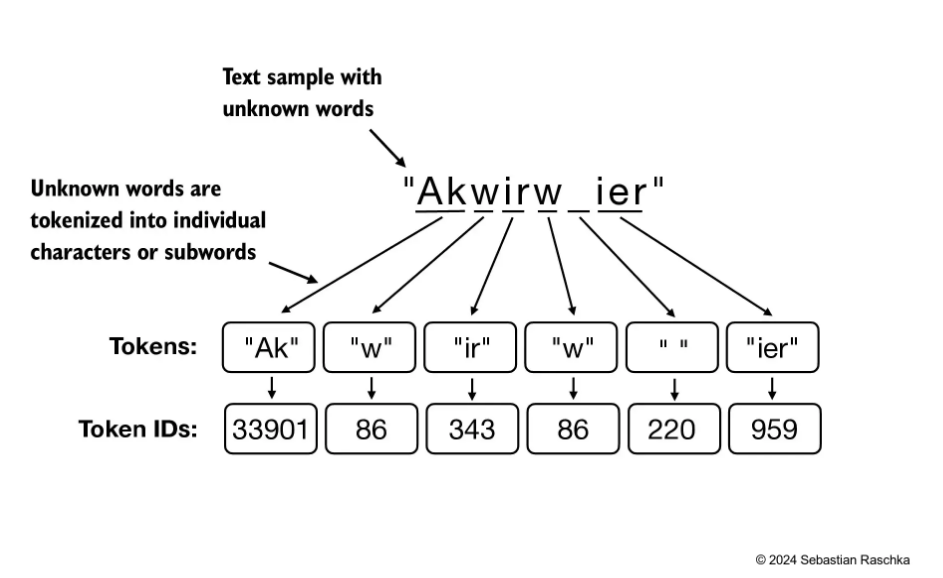

## 2.5 Data sampling with sliding wondow

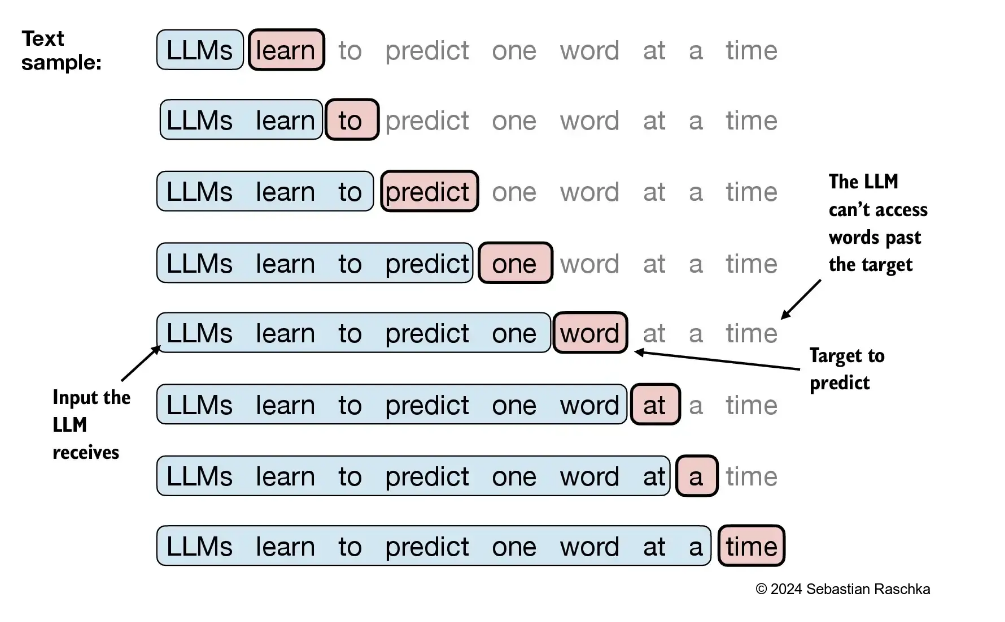

In [46]:
enc_text = tokenizer.encode(raw_text)
enc_sample = enc_text[50:]
print(len(enc_text), len(enc_sample))

5145 5095


In [ ]:
context_size = 4 # Size od the moving window

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1] # +1 means stride = 1 (moves one token at a time)

print(f"x: {x}")
print(f"y:      {y}")


x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [52]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(f"context = {context} ----> {desired} === (desired prediction)")

context = [290] ----> 4920 === (desired prediction)
context = [290, 4920] ----> 2241 === (desired prediction)
context = [290, 4920, 2241] ----> 287 === (desired prediction)
context = [290, 4920, 2241, 287] ----> 257 === (desired prediction)


In [53]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


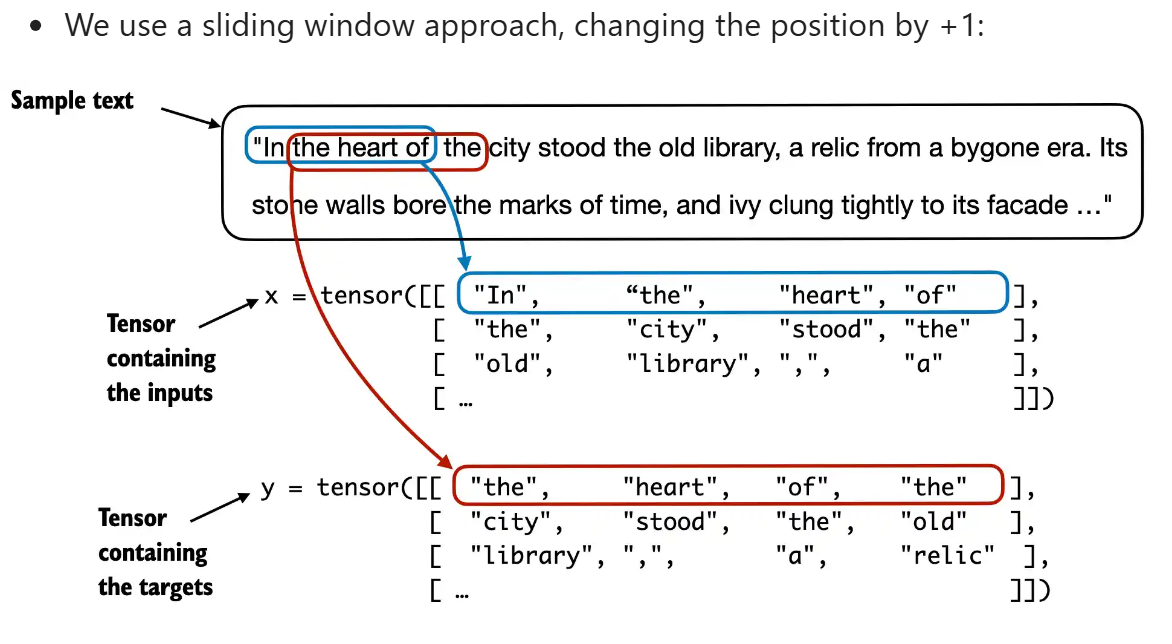

In [64]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length (length of the sliding window)
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [65]:
def create_dataloader_v1(txt, batch_size=4,
                        max_length=256, # Window size
                        stride=128, # how much the window will move
                        shuffle=True, drop_last=True,
                        num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [66]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [67]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [79]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 2.6 Creating token embeddings

Suppose we have the following four input examples with input ids 2, 3, 5, and 1 (after tokenization):

In [80]:
input_ids = torch.tensor([2, 3, 5, 1])

For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3:

In [83]:
vocab_size = 6 # 1 + largest number in input_ids ( (0 -> max_number) => len = max_numer + 1 )
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(num_embeddings= vocab_size, 
                                    embedding_dim= output_dim)

This would result in a 6x3 weight matrix:

In [82]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [ ]:
# To convert a token with id 3 into a 3-dimensional vector, we do the following:
print(embedding_layer(torch.tensor([3]))) # => 4th row in embedding matrix

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [99]:
input_ids = torch.tensor([2, 3, 5, 1])

for i in input_ids:
    print(f"{embedding_layer(i)}  ===  row number {i} -> {embedding_layer.weight[i]}")

tensor([ 1.2753, -0.2010, -0.1606], grad_fn=<EmbeddingBackward0>)  ===  row number 2 -> tensor([ 1.2753, -0.2010, -0.1606], grad_fn=<SelectBackward0>)
tensor([-0.4015,  0.9666, -1.1481], grad_fn=<EmbeddingBackward0>)  ===  row number 3 -> tensor([-0.4015,  0.9666, -1.1481], grad_fn=<SelectBackward0>)
tensor([-2.8400, -0.7849, -1.4096], grad_fn=<EmbeddingBackward0>)  ===  row number 5 -> tensor([-2.8400, -0.7849, -1.4096], grad_fn=<SelectBackward0>)
tensor([0.9178, 1.5810, 1.3010], grad_fn=<EmbeddingBackward0>)  ===  row number 1 -> tensor([0.9178, 1.5810, 1.3010], grad_fn=<SelectBackward0>)


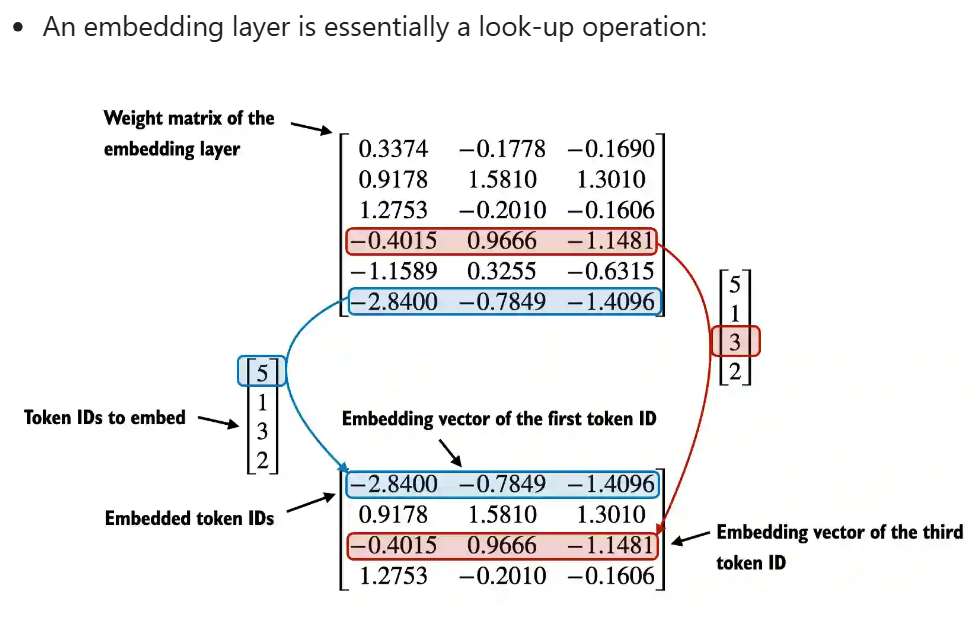

## 2.7 Encoding word positions
> So that if a word is repeated it get's a different weight, because its meaning may differ each time.

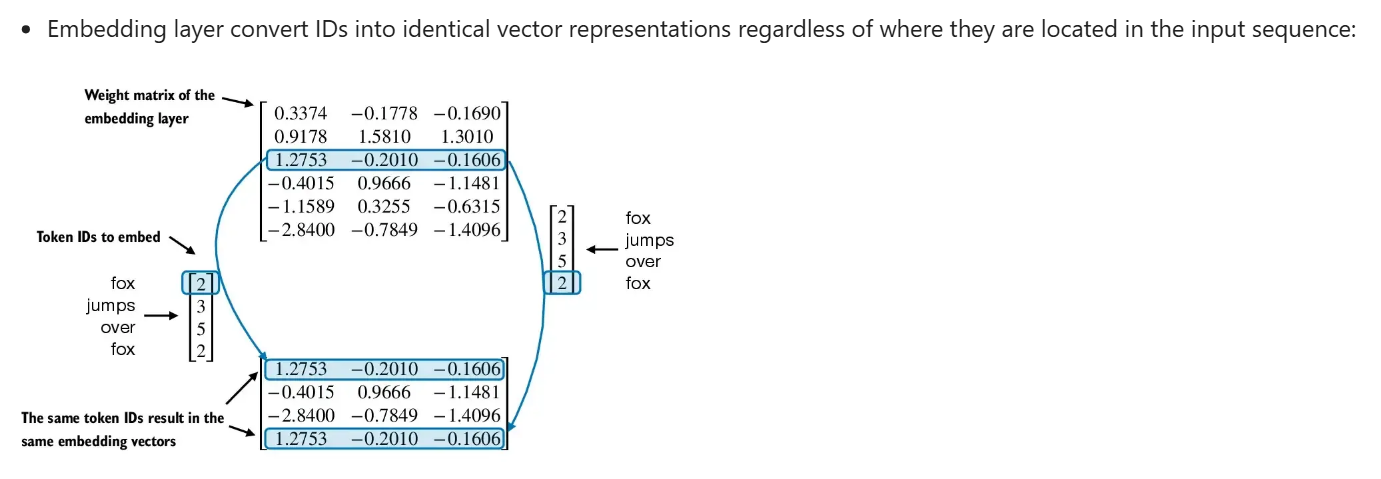
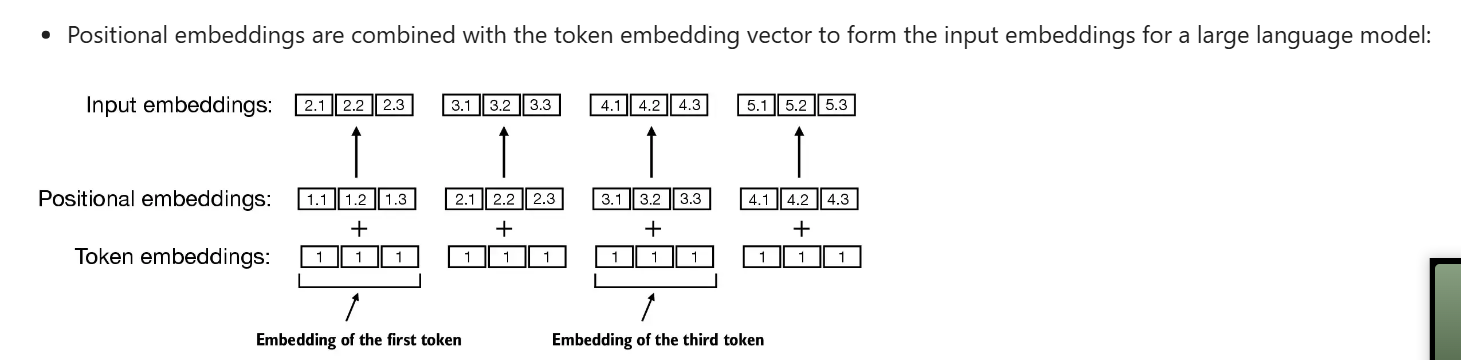

In [100]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [101]:
max_length = 4

# If we have a batch size of 8 with 4 tokens each, this results in a 8 x 4 x 256 tensor:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, 
    max_length=max_length,
    stride=max_length, 
    shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [102]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [104]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(token_embeddings)

torch.Size([8, 4, 256])


In [106]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim) # input size here is the window not the whole vocab

pos_embeddings = pos_embedding_layer(torch.arange(max_length)) # no need for batches
print(pos_embeddings.shape)


torch.Size([4, 256])


In [108]:
input_embeddings = token_embeddings + pos_embeddings # add the position embedding to the original token embedding
print(input_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(input_embeddings)

torch.Size([8, 4, 256])
